# Week 10 - Dimensionality reduction and clustering

## Learning Objectives

* List options available for dimensionality reduction in scikit-learn
* Discuss different clustering algorithms
* Demonstrate clustering in scikit-learn

In [60]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Dimensionality reduction

Many types of data can contain a massive number of features. Whether this is individual pixels in images, transcripts or proteins in -omics data or word occurrances in text data this bounty of features can bring with it several challenges. 

Visualizing more than 4 dimensions directly is difficult complicating our data analysis and exploration. In machine learning models we run the risk of overfitting to the data and having a model that does not generalize to new observations. There are two main approaches to handling this situation:

* Identify important features and discard less important features
* Transform the data into a lower dimensional space

### Identify important features

[Feature selection](http://scikit-learn.org/stable/modules/feature_selection.html) can be used to choose the most informative features. This can improve the performance of subsequent models, reduce overfitting and have practical advantages when the model is ready to be utilized. For example, RT-qPCR on a small number of transcripts will be faster and cheaper than RNAseq, and similarly targeted mass spectrometry such as MRM on a limited number of proteins will be cheaper, faster and more accurate than data independent acquisition mass spectrometry.

There are a variety of approaches for feature selection:

* Remove uninformative features (same value for all, or nearly all, samples)
* Remove features that perform poorly at the task when used alone
* Iteratively remove the weakest features from a model until the desires number is reached

In [61]:
from sklearn.feature_selection import VarianceThreshold

X = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]])
print(X)

[[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 1]
 [0 1 0]
 [0 1 1]]


In [62]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_selected = sel.fit_transform(X)
print(X_selected)

[[0 1]
 [1 0]
 [0 0]
 [1 1]
 [1 0]
 [1 1]]


In [63]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
iris = load_iris()
X, y = iris.data, iris.target
print(X.shape)

(150, 4)


In [64]:
X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
print(X_new.shape)

(150, 2)


When iteratively removing weak features the choice of model is important. We will discuss the different models available for regression and classification next week but there are a few points relevant to feature selection we will cover here.

A linear model is a useful and easily interpreted model, and when used for feature selection L1 regularization should be used. L1 regularization penalizes large coefficients based on their absolute values. This favors a sparse model with weak features having coefficients close to zero. In contrast, L2 regularization penalizes large coefficients  based on their squared value, and this has a tendency to favor many small coefficients rather than a smaller set of larger coefficients.

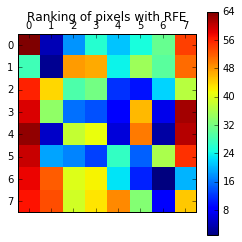

In [65]:
from sklearn import linear_model
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE


# Load the digits dataset
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

# Create the RFE object and rank each pixel
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
rfe = RFE(estimator=clf, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

# Plot pixel ranking
plt.matshow(ranking)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

The disadvantage with L1 regularization is that if multiple features are correlated only one of them will have a high coefficient.

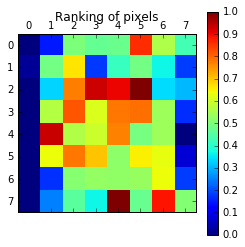

In [66]:
from sklearn.linear_model import RandomizedLogisticRegression
randomized_logistic = RandomizedLogisticRegression()

# Load the digits dataset
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

randomized_logistic.fit(X, y)

ranking = randomized_logistic.scores_.reshape(digits.images[0].shape)


# Plot pixel ranking
plt.matshow(ranking)
plt.colorbar()
plt.title("Ranking of pixels")
plt.show()

Also important is to normalize the means and variances of the features before comparing the coefficients. The approaches we covered last week are crucial for feature selection from a linear model.

A limitation of linear models is that any interactions must be hand coded. A feature that is poorly predictive overall may actually be very powerful but only in a limited subgroup. This might be missed in a linear model when we would prefer to keep the feature.

Any model exposing a `coef_` or `feature_importances_` attribute can be used with the `SelectFromModel` class for feature selection. [Forests of randomized decision trees](http://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees) handle interactions well and unlike some of the other models do not require careful tuning of parameters to achieve reasonable performance.

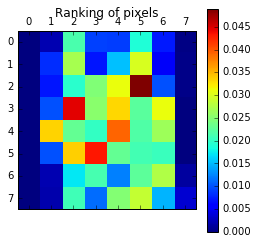

In [67]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)

# Load the digits dataset
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

clf.fit(X, y)

ranking = clf.feature_importances_.reshape(digits.images[0].shape)

# Plot pixel ranking
plt.matshow(ranking)
plt.colorbar()
plt.title("Ranking of pixels")
plt.show()

### Transformation into lower dimensional space

An alternative approach is to [transform the data](http://scikit-learn.org/stable/modules/decomposition.html) in such a way that the variance observed in the features is maintained while only using a smaller number of dimensions. This approach includes all the features so is not a simpler model when considering the entire process from data acquisition onwards. It can however improve the performance of subsequent algorithms and is a very popular approach for visualization and the initial data analysis phase of a project.

The classical method is Principal Components Analysis although other algorithms are also available. Given a set of features usually some will be at least weakly correlated. By performing an orthogonal transformation a reduced number of features that are uncorrelated can be chosen that maintains as much of the variation in the original data as possible.

An orthogonal transformation simply means that the data is rotated and reflected about the axes.

Scikit-learn has several different implementations of PCA available together with other techniques performing a similar function.

Most of these techniques are unsupervised. Linear Discriminant Analysis (LDA) is one algorithm that can include labels and will attempt to create features that account for the greatest amount of variance between classes.



explained variance ratio (first two components): [ 0.92461621  0.05301557]


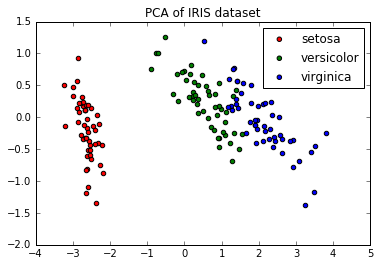

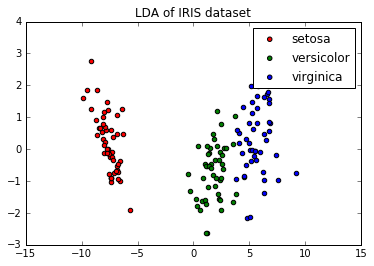

In [68]:
# http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#example-decomposition-plot-pca-vs-lda-py

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, label=target_name)
plt.legend(scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, label=target_name)
plt.legend(scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

### Exercises

1. Apply feature selection to the [Olivetti faces dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces), identifying the most important 25% of features.
2. Apply PCA and LDA to the digits dataset used above

## Clustering

In clustering we attempt to group observations in such a way that observations assigned to the same cluster are more similar to each other than to observations in other clusters.

Although labels may be known, clustering is usually performed on unlabeled data as a step in exploratory data analysis.

Previously we looked at the [Otsu thresholding method](https://en.wikipedia.org/wiki/Otsu's_method) as a basic example of clustering. This is very closely related to k-means clustering. A variety of other methods are available with different characteristics.

The best method to use will vary developing on the particular problem.

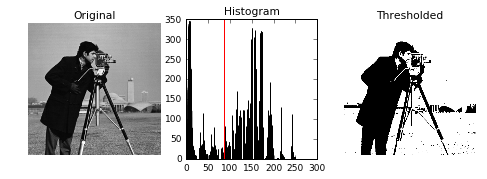

In [69]:
import matplotlib
import matplotlib.pyplot as plt

from skimage.data import camera
from skimage.filters import threshold_otsu


matplotlib.rcParams['font.size'] = 9


image = camera()
thresh = threshold_otsu(image)
binary = image > thresh

#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2.5))
fig = plt.figure(figsize=(8, 2.5))
ax1 = plt.subplot(1, 3, 1, adjustable='box-forced')
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3, sharex=ax1, sharey=ax1, adjustable='box-forced')

ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Original')
ax1.axis('off')

ax2.hist(image)
ax2.set_title('Histogram')
ax2.axvline(thresh, color='r')

ax3.imshow(binary, cmap=plt.cm.gray)
ax3.set_title('Thresholded')
ax3.axis('off')

plt.show()

### Different clustering algorithms

![Cluster comparison](files/plot_cluster_comparison_001.png)
[Cluster comparison](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)


The following algorithms are provided by [scikit-learn](http://scikit-learn.org/stable/modules/clustering.html)

* K-means
* Affinity propagation
* Mean Shift
* Spectral clustering
* Ward
* Agglomerative Clustering
* DBSCAN
* Birch


K-means clustering divides samples between clusters by attempting to minimize the within-cluster sum of squares. It is an iterative algorithm repeatedly updating the position of the centroids (cluster centers), re-assigning samples to the best cluster and repeating until an optimal solution is reached. The clusters will depend on the starting position of the centroids so k-means is often run multiple times with random initialization and then the best solution chosen.

[Affinity Propagation](http://science.sciencemag.org/content/315/5814/972) operates by passing messages between the samples updating a record of the exemplar samples. These are samples that best represent other samples. The algorithm functions on an affinity matrix that can be eaither user supplied or computed by the algorothm. Two matrices are maintained. One matrix records how well each sample represents other samples in the dataset. When the algorithm finishes the highest scoring samples are chosen to represent the clusters. The second matrix records which other samples best represent each sample so that the entire dataset can be assigned to a cluster when the algorithm terminates.

[Mean Shift](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.76.8968&rep=rep1&type=pdf) iteratively updates candidate centroids to represent the clusters. The algorithm attempts to find areas of higher density.

Spectral clustering operates on an affinity matrix that can be user supplied or computed by the model. The algorithm functions by minimizing the value of the links cut in a graph created from the affinity matrix. By focusing on the relationships between samples this algorithm performs well for non-convex clusters.

Ward is a type of agglomerative clustering using minimization of the within-cluster sum of squares to join clusters together until the specified number of clusters remain.

Agglomerative clustering starts all the samples in their own cluster and then progressively joins clusters together minimizing some performance measure. In addition to minimizing the variance as seen with Ward other options are, 1) minimizing the average distance between samples in each cluster, and 2) minimizing the maximum distance between observations in each cluster.

DBSCAN is another algorithm that attempts to find regions of high density and then expands the clusters from there.

[Birch](http://scikit-learn.org/stable/modules/clustering.html#birch) is a tree based clustering algorithm assigning samples to nodes on a tree


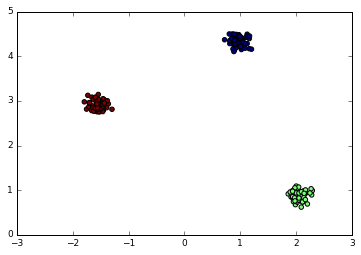

In [70]:
from sklearn import cluster, datasets

dataset, true_labels = datasets.make_blobs(n_samples=200, n_features=2, random_state=0,
                                           centers=3, cluster_std=0.1)

fig, ax = plt.subplots(1,1)
ax.scatter(dataset[:,0], dataset[:,1], c=true_labels)
plt.show()

# Clustering algorithm can be used as a class
means = cluster.KMeans(n_clusters=2)
prediction = means.fit_predict(dataset)

### Model evaluation

Several approaches have been developed for evaluating clustering models but are generally limited in requiring the true clusters to be known. In the general use case for clustering this is not known with the goal being exploratory. 

Ultimately, a model is just a tool to better understand the structure of our data. If we are able to gain insight from using a clustering algorithm then it has served its purpose.

[The metrics](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) available are Adjusted Rand Index, Mutual Information based scores, Homogeneity, completeness, v-measure, and silhouette coefficient. Of these, only the silhouette coefficient does not require the true clusters to be known.

Although the silhouette coefficient can be useful it takes a very similar approach to k-means, favoring convex clusters over more complex, equally valid, clusters.

### How to determine number of clusters

One important use for the model evaluation algorithms is in choosing the number of clusters. The clustering algorithms take as parameters either the number of clusters to partition a dataset into or other scaling factors that ultimately determine the number of clusters. It is left to the user to determine the correct value for these parameters.

As the number of clusters increases the fit to the data will always improve until each point is in a cluster by itself. As such, classical optimization algorithms searching for a minimum or maximum score will not work. Often, the goal is to find an inflection point.

If the cluster parameter is too low adding an additional cluster will have a large impact on the evaluation score. The gradient will be high at numbers of clusters less than the true value. If the cluster parameter is too high adding an additional cluster will have a small impact on the evaluation score. The gradient will be low at numbers of clusters higher than the true value.

At the correct number of clusters the gradient should suddenly change, this is an inflection point.

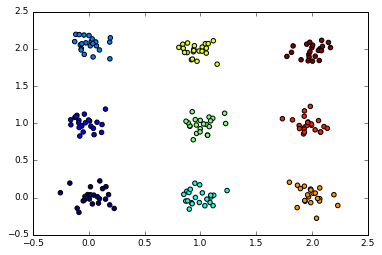

In [71]:
from sklearn import cluster, datasets, metrics


dataset, true_labels = datasets.make_blobs(n_samples=200, n_features=2, random_state=0,
                                           centers=[[x,y] for x in range(3) for y in range(3)], cluster_std=0.1)


fig, ax = plt.subplots(1,1)
ax.scatter(dataset[:,0], dataset[:,1], c=true_labels)
plt.show()

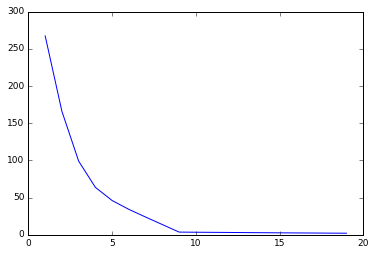

In [72]:
inertia = []
predictions = []
for i in range(1,20):
    means = cluster.KMeans(n_clusters=i)
    prediction = means.fit_predict(dataset)
    inertia.append(means.inertia_)
    predictions.append(prediction)


plt.plot(range(1,20), inertia)
plt.show()

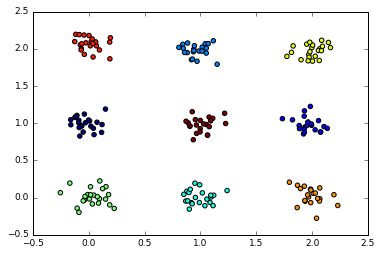

In [73]:
plt.scatter(dataset[:,0], dataset[:,1], c=predictions[8])
plt.show()

This is an ideal case with clusters that can be clearly distinguished - convex clusters with similar distributions and large gaps between the clusters. Most real world datasets will not be as easy to work with and determining the correct number of clusters will be more challenging. As an example, compare the performance between challenges 1 and 2 (unknown number of clusters) and challenge 3 (known number of clusters) in [table 2 of this report on automated FACS](http://www.nature.com/nmeth/journal/v10/n3/full/nmeth.2365.html).

There is a [pull request on the scikit-learn repository](https://github.com/scikit-learn/scikit-learn/pull/4301) to add several automated algorithms to identify the correct number of clusters but it has not been integrated.

### Exercises

1. Using the grid of blobs sample dataset investigate how different cluster shapes and distances alter the plot of inertia with number of clusters. Is the plot still interpretable if the distances are 1/2, 1/4, 1/8, etc? If the variance in the first and second dimensions is unequal is the plot still interpretable?
2. Does using a different algorithm improve performance?